In [ ]:
!pip install keras-nlp

In [ ]:
import  os
import  numpy               as np
import  tensorflow          as tf
from    tensorflow          import keras
import  keras_nlp
import  matplotlib.pyplot   as plt

# Transformer

### Data


In [ ]:
# https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip
dset_train_f    = "simplebooks-92-raw_train.txt"
dset_valid_f    = "simplebooks-92-raw_valid.txt"
dset_test_f     = "simplebooks-92-raw_test.txt"

!wget -O {dset_train_f} https://www.dropbox.com/scl/fi/r6vnn7vccpvscvmzabmvf/simplebooks-92-raw_train.txt?rlkey=thwnurvjrda737sr8283qpdkg&dl=0
!wget -O {dset_valid_f} https://www.dropbox.com/scl/fi/txlel36qe8nxz7jth95xp/simplebooks-92-raw_valid.txt?rlkey=8sdbtycdx2ppokcybaolvrx7j&dl=0
!wget -O {dset_test_f} https://www.dropbox.com/scl/fi/3j9eifu45sdwnhof3r63q/simplebooks-92-raw_test.txt?rlkey=5c8z385wsu925h9zugz7p2d8v&dl=0

--2024-03-05 17:02:28--  https://www.dropbox.com/scl/fi/r6vnn7vccpvscvmzabmvf/simplebooks-92-raw_train.txt?rlkey=thwnurvjrda737sr8283qpdkg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8c694483631187b5763632c391.dl.dropboxusercontent.com/cd/0/inline/COgf9t_TVfT5Bc2Sq51dEgMIddc4srq8DZJc7wYzkvwA84uHJ7Mozkyrrm019mjCibFJ8-E-ofCNYDyAceJK47bNRmyXizOyCq6erInGx0pRZzbn6MalyuLP1vnSVAVbz7g/file# [following]
--2024-03-05 17:02:29--  https://uc8c694483631187b5763632c391.dl.dropboxusercontent.com/cd/0/inline/COgf9t_TVfT5Bc2Sq51dEgMIddc4srq8DZJc7wYzkvwA84uHJ7Mozkyrrm019mjCibFJ8-E-ofCNYDyAceJK47bNRmyXizOyCq6erInGx0pRZzbn6MalyuLP1vnSVAVbz7g/file
Resolving uc8c694483631187b5763632c391.dl.dropboxusercontent.com (uc8c694483631187b5763632c391.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:6017:15::a27d:20f
Conne

In [ ]:
!wget -O vocab_10000.txt https://www.dropbox.com/scl/fi/aix95cadh32i9ylzjzz0m/vocab_10000.txt?rlkey=qcwpxhw34c8z2x7hue37zu79d&dl=0
!wget -O transf_v10000_s128_h4_e50.h5 https://www.dropbox.com/scl/fi/la654e3fsjfn6iwrlmm1d/transf_v10000_s128_h4_e50.h5?rlkey=9qkdroty1i2l9lu1euaxjtkvg&dl=0
!wget -O transf_v10000_s128_h4_e200.h5 https://www.dropbox.com/scl/fi/tvevf1ocgatw2v0nl624f/transf_v10000_s128_h4_e200.h5?rlkey=0pxwmhyicvkyxdae3jsc0znsb&dl=0

--2024-03-05 17:02:38--  https://www.dropbox.com/scl/fi/aix95cadh32i9ylzjzz0m/vocab_10000.txt?rlkey=qcwpxhw34c8z2x7hue37zu79d
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0df5f12e45d4a9308c3666c76.dl.dropboxusercontent.com/cd/0/inline/COjf74_jPiGm6Ml6i-6VxWAVTx0fsi0v_jlHrilFcLopPPWN2aDOQ5TkEPMv8RTI48tIk14DcXdv43E6eTajXgi1-f_HgkEHUwqXzctBVjbiInHN_xuLX5AEb5QM7wGfWJw/file# [following]
--2024-03-05 17:02:39--  https://ucb0df5f12e45d4a9308c3666c76.dl.dropboxusercontent.com/cd/0/inline/COjf74_jPiGm6Ml6i-6VxWAVTx0fsi0v_jlHrilFcLopPPWN2aDOQ5TkEPMv8RTI48tIk14DcXdv43E6eTajXgi1-f_HgkEHUwqXzctBVjbiInHN_xuLX5AEb5QM7wGfWJw/file
Resolving ucb0df5f12e45d4a9308c3666c76.dl.dropboxusercontent.com (ucb0df5f12e45d4a9308c3666c76.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:6019:15::a27d:40f
Connecting to ucb0

### Parameters

In [ ]:
BATCH_SIZE              = 64    # size fo the batch during training
SEQ_LEN                 = 128   # maximum number of words acceptes in parallel by the model
MIN_TRAIN_SEQ_LEN       = 400   # this way samples are rather long, and there are 202757 samples

EMBED_DIM               = 128   # word embedding vector length
NUM_HEADS               = 4     # number of attention heads
VOCAB_SIZE              = 10000 # size of the covabulary

EPOCHS                  = 50    # number of training epochs

### Tokenizer

In [ ]:
def load_dset():
    """
    load the books used for training and validating the model
    this function should be invoked when training a new model
    return:
        [tuple] of two [Tf TextLineDataset], one for trainig, one for validation
    """

    dset_train  = tf.data.TextLineDataset( dset_train_f )
    dset_train  = dset_train.filter( lambda x: tf.strings.length( x ) > MIN_TRAIN_SEQ_LEN )
    dset_train  = dset_train.batch( BATCH_SIZE )
    dset_train  = dset_train.shuffle( buffer_size=1024 )

    dset_valid  = tf.data.TextLineDataset( dset_valid_f )
    dset_valid  = dset_valid.filter( lambda x: tf.strings.length( x ) > MIN_TRAIN_SEQ_LEN )
    dset_valid  = dset_valid.batch( BATCH_SIZE )

    return dset_train, dset_valid

In [ ]:
def load_vocab( fname=None ):
    """
    read the vocabulary from file

    input:
        fname:      [str] file name, if None is used a convention based on VOCAB_SIZE
    """

    if fname is None:
        fname   = f"vocab_{VOCAB_SIZE}.txt"

    with open( fname, 'r' ) as f:
        vocab   = f.read()
    vocab   = vocab.split()

    return vocab

In [ ]:
def set_vocab( dset ):
    """
    set the vocabulary, compute it, or read from file if already existing

    input:
        dset:       [Tf TextLineDataset] the dataset on which teh vocabulary is computed

    return:
        [list] the vocabulary, a list of words
    """

    fname   = f"vocab_{VOCAB_SIZE}.txt"

    if os.path.isfile( fname ):
        vocab   = load_vocab( fname=fname )
        return vocab

    vocab   = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        dset,
        vocabulary_size = VOCAB_SIZE,
        lowercase       = True,
        reserved_tokens = [ "[PAD]", "[UNK]", "[BOS]" ]
    )

    with open( fname, 'w' ) as f:
        f.write( "\n".join( w for w in vocab ) )

    return vocab

In [ ]:
def set_tokenizer( vocab ):
    """
    set a keras_nlp tokenizer from the given vocabulary

    input:
        vocab:      [list]
    return:
        [keras_nlp.tokenizers.Tokenizer]
    """

    tokenizer   = keras_nlp.tokenizers.WordPieceTokenizer(
        vocabulary      = vocab,
        sequence_length = SEQ_LEN,
        lowercase       = True
    )

    return tokenizer

In [ ]:
def tokenize_dset( tokenizer, dset_tr, dset_vl ):
    """
    tokenize the training and validation sets, using a keras_nlp tokenizer

    input:
        tokenizer:  [keras_nlp.tokenizers.Tokenizer]
        tset:       [Tf TextLineDataset]  training set
        vset:       [Tf TextLineDataset]  validation set
    return:
        [tuple] training and validation sets tokenized for training
    """

    # adds a start token and make uniform the sequence of token by adding [PAD]'s
    start_packer    = keras_nlp.layers.StartEndPacker(
        sequence_length = SEQ_LEN,
        start_value     = tokenizer.token_to_id( "[BOS]" )
    )

    def func( inputs ):
        """
        help function to apply tokenization and sequence packing to an input sample
        """
        outputs     = tokenizer( inputs )
        features    = start_packer( outputs )
        return features, outputs

    # tokenize train and validation sequences
    dset_train  = dset_tr.map( func, num_parallel_calls=tf.data.AUTOTUNE )
    dset_train  = dset_train.prefetch( tf.data.AUTOTUNE )
    dset_valid  = dset_vl.map( func, num_parallel_calls=tf.data.AUTOTUNE )
    dset_valid  = dset_valid.prefetch( tf.data.AUTOTUNE )

    return dset_train, dset_valid


In [ ]:
dset_train, dset_valid  = load_dset()
vocab                   = set_vocab( dset_train )
tokenizer               = set_tokenizer( vocab )
tset_train, tset_valid  = tokenize_dset( tokenizer, dset_train, dset_valid )

In [ ]:
s   = "the cat in on the table"
tokenizer.tokenize( s )

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  97, 1321,  101,  112,   97,  572,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [ ]:
tokenizer.detokenize( [ 1321 ] )

<tf.Tensor: shape=(), dtype=string, numpy=b'cat'>

In [ ]:
w   = 'yellowish'
tokenizer.tokenize( w )

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([1064,  975,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [ ]:
print( tokenizer.detokenize( [ 1064 ] ) )
print( tokenizer.detokenize( [ 975 ] ) )

tf.Tensor(b'yellow', shape=(), dtype=string)
tf.Tensor(b'##ish', shape=(), dtype=string)


In [ ]:
w   = 'unicorn'
tokenizer.tokenize( w )

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([5028, 5039, 3608,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [ ]:
print( tokenizer.detokenize( [ 5028 ] ) )
print( tokenizer.detokenize( [ 5039 ] ) )
print( tokenizer.detokenize( [ 3608 ] ) )

tf.Tensor(b'un', shape=(), dtype=string)
tf.Tensor(b'##ico', shape=(), dtype=string)
tf.Tensor(b'##rn', shape=(), dtype=string)


### Transformer Class

In [ ]:
class TransDecoder( object ):
    """
    this class implements an essential Transformer decoder
    NOTE there is already in Keras a TransformerDecoder layer, but by building it in pieces it is possible
    to isolate the part that implements attention, in order to exctract and visualize attention results
    """

    def __init__( self, num_heads=NUM_HEADS, lenght=SEQ_LEN, dim=EMBED_DIM, summary=False ):
        """
        initialization of the class
        inputs:
            num_heads   [int] number of attention heads
            lenght      [int] length of the word sequence
            dim         [int] word embedding dimension
            summary     [bool] generate a summary of the created model
        """
        self.num_heads  = num_heads
        self.lenght     = lenght
        self.dim        = dim
        self.key_dim    = dim // num_heads
        self.embedding  = self._embedding()
        self.attention  = self._attention_keras()
        self.model      = self.create_model()


    def _embedding( self ):
        """
        define the embedding part of the model
        """
        embedding   = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size = VOCAB_SIZE,
            sequence_length = self.lenght,
            embedding_dim   = self.dim,
            mask_zero       = True
        )
        return embedding


    def _attention_keras( self ):
        """
        define the attention part of the model
        """
        att         = keras.layers.MultiHeadAttention(
                num_heads   = self.num_heads,
                key_dim     = self.key_dim
        )
        return att


    def create_model( self ):
        """
        create the model
        """

        inputs      = keras.layers.Input( shape=( None, ), dtype=tf.int32 )
        x           = self.embedding( inputs )
        x           = self.attention( x, x )
        x           = keras.layers.LayerNormalization()( x )
        outputs     = keras.layers.Dense( VOCAB_SIZE )( x )
        model       = keras.Model( inputs=inputs, outputs=outputs )

        return model


    def get_attention( self, x ):
        """
        input:
            x   [np.array] tokenized sequence
        return:
            [tf.Tensor] attention matrix
        """
        if x.ndim < 2:
            x       = x[ tf.newaxis, : ]

        x           = self.embedding( x )
        y           = self.attention( x, x, return_attention_scores=True, use_causal_mask=True ) # no bi-directional attention
        return y

### Train/test functions

In [ ]:
def train_model( model, tr_set, vl_set ):
    """
    train the model
    input:
        model   [keras.Model] the model to train
        tset    [Tf TextLineDataset] training set
        vset    [Tf TextLineDataset] validation set
    return:
        [tf.History] the history of the training
    """

    loss        = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True )
    perplexity  = keras_nlp.metrics.Perplexity( from_logits=True, mask_token_id=0 )
    model.compile( optimizer="adam", loss=loss, metrics=[ perplexity ] )
    history     = model.fit( tr_set, validation_data=vl_set, verbose=1, epochs=EPOCHS )

    return history

In [ ]:
def save_model( model, history, name=None, plot=False ):
    """
    save a trained model
    input:
        model   [keras.Model] the model to train
        history [tf.History] the history of the training
        name    [str] of the file to save the model, if None is generated internally
        plot    [bool] generate a graphic representation of teh model
    """
    if name is None:
        name = f"transf_v{VOCAB_SIZE}_s{SEQ_LEN}_h{NUM_HEADS}_e{EPOCHS}"
    if plot:
        keras.utils.plot_model( model, to_file = name + ".png", show_shapes=True, show_layer_names=True )

    try:
        model.save_weights( name + ".h5" )
    except ValueError:
        for i in range( len( model.weights ) ):
            model.weights[ i ]._handle_name = f"{model.weights[ i ].name}_{i}"
        model.save_weights( name + ".h5" )

    his         = history.history
    fmt         = "{:04d}   {:^9.5f} {:^9.5f} {:^9.3f} {:^9.3f}\n"

    with open( name + ".log", 'w' ) as f:
        f.write( "epoch    loss    perplexity  val_loss val_perplexity\n" )
        f.write( 60 *"=" + "\n" )
        for e in history.epoch:
            f.write( fmt.format( e, his[ 'loss' ][e], his[ 'perplexity' ][e], his[ 'val_loss' ][e], his[ 'val_perplexity' ][e] ) )
        f.write( 60 *"=" + "\n" )

In [ ]:
def get_attention( model, tokenizer, prompt ):
    """
    get the attention matrices

    input:
        model       [keras_nlp.model]
        tokenizer   [keras_nlp.tokenizers]
        prompt      [str]
    """

    prompt_out      = prompt.lower().split() + [ "[PAD]" ]
    prompt_list     = [ "[BOS]" ] + prompt.lower().split()

    # convert the list of words into list of tokens, and then to tensor
    prompt_tokens   = [ tokenizer.token_to_id( w ) for w in prompt_list ]
    prompt_tokens   = tf.convert_to_tensor( prompt_tokens )
    prompt_tokens   = prompt_tokens[ tf.newaxis, : ]

    _, attention    = model.get_attention( prompt_tokens )
    return attention[ 0 ]


In [ ]:
def plot_attention( attention, prompt, shift_out=False ):
    """
    plot the attention matrices on PDF files

    input:
        attention   [tensorflow.python.framework.ops.EagerTensor]
        prompt      [str]
        shift_out   [boolean] shift the output senqence taking into account the [BOS] token
    """

    prompt_out      = prompt.lower().split() + [ "[PAD]" ]
    prompt_list     = [ "[BOS]" ] + prompt.lower().split()

    for h, head in enumerate( attention ):
        axis        = plt.gca()
        axis.matshow( head.numpy() )
        axis.set_xticks( range( len( prompt_list ) ) )
        axis.set_yticks( range( len( prompt_list ) ) )
        axis.set_xticklabels( prompt_list, rotation=90 )

        if shift_out:
            axis.set_yticklabels( prompt_out )
        else:
            axis.set_yticklabels( prompt_list )

        # plt.savefig( f"head{NUM_HEADS}_{h}.pdf" )
        # plt.close()
        plt.show()


### Usage

In [ ]:
transf  = TransDecoder()

In [ ]:
# load weights from a pre-trained model

# model_name  = "transf_v10000_s128_h4_e50.h5"
model_name  = "transf_v10000_s128_h4_e200.h5"

transf.model.load_weights( model_name )

In [ ]:
# train model from scratch

# history     = train_model( transf.model, tset_train, tset_valid )
# save_model( transf.model, history )

In [ ]:
# try to use a prompt where there are clear links between certain words

prompt      = "the cat on the table is black"

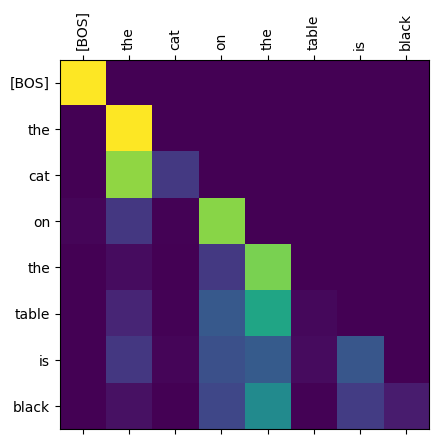

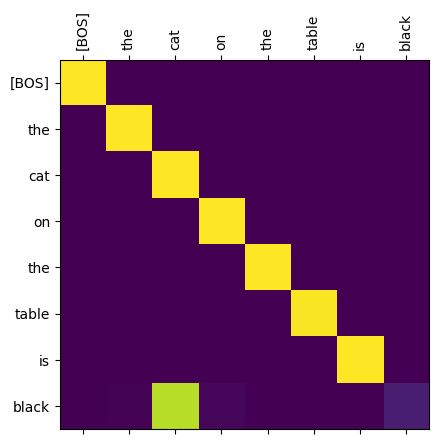

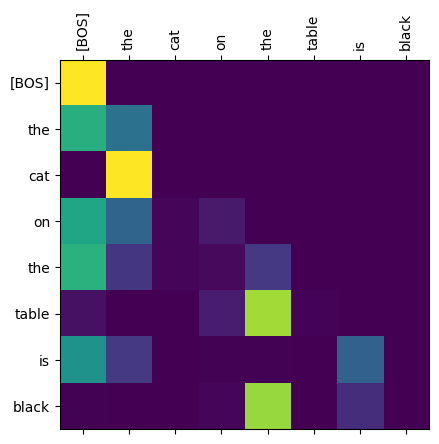

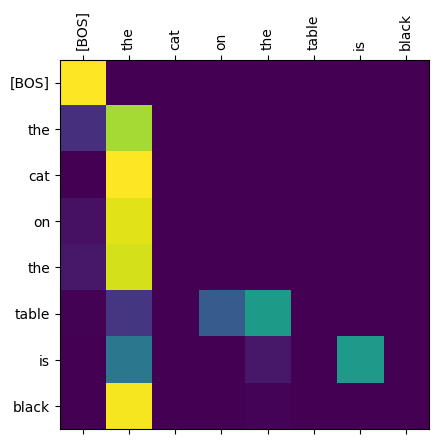

In [ ]:
att         = get_attention( transf, tokenizer, prompt )
plot_attention( att, prompt )

# Simple GPT

### Data

In [ ]:
!wget -O gpt_v10000_s128_l2_h4_e50.h5 https://www.dropbox.com/scl/fi/ryn31mv5ne6k9mc18kffh/gpt_v10000_s128_l2_h4_e50.h5?rlkey=p8x4bhe5oxb8lpw3f54i970ud&dl=0
!wget -O gpt_v10000_s128_l2_h4_e100.h5 https://www.dropbox.com/scl/fi/ie0y2rk65z2encjhj203x/gpt_v10000_s128_l2_h4_e100.h5?rlkey=xo46jcgl1qywu5fm9bpzclg0z&dl=0

--2024-03-05 17:03:00--  https://www.dropbox.com/scl/fi/ryn31mv5ne6k9mc18kffh/gpt_v10000_s128_l2_h4_e50.h5?rlkey=p8x4bhe5oxb8lpw3f54i970ud
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca43b24c7e0912a91677db716bb.dl.dropboxusercontent.com/cd/0/inline/COjV-OTdErnntgYMibxIXXNETT0uaeJefuE6HsG3eoprd-z6bE58G8lyU6uGuvmv2CYmqlDSdBXkUkhb9-APQoAYIzVUYvRNfFHDQo9M9Bpgqk-id1BDLvJU0lJquQiyl5M/file# [following]
--2024-03-05 17:03:02--  https://uca43b24c7e0912a91677db716bb.dl.dropboxusercontent.com/cd/0/inline/COjV-OTdErnntgYMibxIXXNETT0uaeJefuE6HsG3eoprd-z6bE58G8lyU6uGuvmv2CYmqlDSdBXkUkhb9-APQoAYIzVUYvRNfFHDQo9M9Bpgqk-id1BDLvJU0lJquQiyl5M/file
Resolving uca43b24c7e0912a91677db716bb.dl.dropboxusercontent.com (uca43b24c7e0912a91677db716bb.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:6019:15::a27d:40f
Conn

### Parameters

In [ ]:
BATCH_SIZE              = 64    # size fo the batch during training
SEQ_LEN                 = 128   # maximum number of words acceptes in parallel by the model
MIN_TRAIN_SEQ_LEN       = 400   # this way samples are rather long, and there are 202757 samples
NUM_TOKENS_TO_GENERATE  = 80    # default number of tokens to generate for completion

EMBED_DIM               = 256   # word embedding vector length
FEED_FORWARD_DIM        = 256   # size of the hidden dense layer in the Transformer decoder
NUM_HEADS               = 4     # number of attention heads
NUM_LAYERS              = 2     # number of Transformer decoder blocks
VOCAB_SIZE              = 10000 # size of the covabulary

EPOCHS                  = 50    # number of training epochs

### Functions

In [ ]:
def create_model():
    """
    create the model, made by an embedder, and a variable number of Transformer blocks
    """

    inputs      = keras.layers.Input( shape=(None,), dtype=tf.int32 )   # lenght is variable

    embedding   = keras_nlp.layers.TokenAndPositionEmbedding(           # embedding (and position) layer
        vocabulary_size = VOCAB_SIZE,
        sequence_length = SEQ_LEN,
        embedding_dim   = EMBED_DIM,
        mask_zero       = True
    )
    x           = embedding( inputs )

    for i in range( NUM_LAYERS ):
        name    = "decoder_{:02d}".format( i )
        decoder = keras_nlp.layers.TransformerDecoder(                  # Transformer decoder block
            num_heads           = NUM_HEADS,
            intermediate_dim    = FEED_FORWARD_DIM
        )
        x = decoder( x )                                                # one argument only skips cross-attention.

    outputs     = keras.layers.Dense( VOCAB_SIZE )( x )                 # final dense layer
    model       = keras.Model(inputs=inputs, outputs=outputs)           # define the Keras model

    return model

In [ ]:
def text_to_token( text, tokenizer ):
    """
    transform a text into tokens

    input:
        text        [str]
        tokenizer   [keras_nlp.tokenizers]
    return:         [np.array]  array of int
    """
    tokens      = tokenizer( text.lower() )
    return tokens.numpy()


def token_to_text( tokens, tokenizer ):
    """
    transform tokens into text

    input:
        tokens      [tf.Tensor]  tensor of int
        tokenizer   [keras_nlp.tokenizers]
    return:         [bytes]
    """
    text        = tokenizer.detokenize( tokens )
    return text.numpy()

In [ ]:
def prediction( model, tokenizer, prompt=None, k=0 ):
    """
    output the token predictions  using a trained model, a tokenizer, and a prompt

    input:
        model       [keras_nlp.model]
        tokenizer   [keras_nlp.tokenizers]
        prompt      [str] or None to generate spontaneously
        k           [int] how many probabilities to output, if 0 the largest only

    """
    prompt_bos      = [ tokenizer.token_to_id( "[BOS]" ) ]
    prompt_tokens   = tokenizer( prompt.lower() )
    prompt_tokens   = tf.squeeze( tf.gather( prompt_tokens, tf.where( prompt_tokens ) ) )
    prompt_tokens   = tf.concat( [ prompt_bos, prompt_tokens ], 0 )
    prompt_tokens   = prompt_tokens[ tf.newaxis, : ]
    prediction      = model( prompt_tokens )
    if k > 1:
        max_prob        = tf.math.top_k( prediction, k=k )[ 1 ]
    else:
        max_prob        = tf.argmax( prediction, axis=-1 )

    return token_to_text( max_prob[ 0 ], tokenizer )

In [ ]:
def next_token( model, tokenizer, prompt=None, k=0 ):
    """
    output the predictions for a next token using a trained model, a tokenizer, and a prompt

    input:
        model       [keras_nlp.model]
        tokenizer   [keras_nlp.tokenizers]
        prompt      [str] or None to generate spontaneously
        k           [int] how many probabilities to output, if 0 the largest only

    """
    token_pred  = prediction( model, tokenizer, prompt=prompt, k=k )

    if k==0:            # when only the larest probability is returned, the format is a string
        return token_pred.split()[ - 1 ]

    # otherwise, it is an array, and the next token is the last element
    return token_pred[ -1 ]

In [ ]:
def complete( model, tokenizer, prompt=None, method="top_p", max_length=NUM_TOKENS_TO_GENERATE ):
    """
    generate text using a trained model, a tokenizer, and a prompt

    input:
        model       [keras_nlp.model]
        tokenizer   [keras_nlp.tokenizers]
        prompt      [str] or None to generate spontaneously
        method      [str] one of: https://keras.io/examples/generative/text_generation_gpt/
                "greedy" "beam" "top_k" "top_p"
    return:         [bytes]
    """
    prompt_bos      = [ tokenizer.token_to_id( "[BOS]" ) ]

    prompt_tokens   = tokenizer( prompt.lower() )
    # prompt_tokens   = tf.squeeze( tf.gather( prompt_tokens, tf.where( prompt_tokens ) ) )
    # prompt_tokens   = tf.concat( [ prompt_bos, prompt_tokens ], axis=0 )
    prompt_tokens   = tf.concat( [ prompt_bos, prompt_tokens[ :-1 ] ], axis=0 )

    prompt_len      = tf.math.count_nonzero( prompt_tokens, dtype=tf.int32 ).numpy()

    prompt_tokens   = prompt_tokens[ tf.newaxis, : ]


    def predict_fn( inputs, cache, index ):
        logits          = model( inputs )[ :, index-1, : ]
        hidden_states   = None
        return logits, hidden_states, cache


    sampler = None

    if method == "greedy":
        sampler     = keras_nlp.samplers.GreedySampler()
    elif method == "beam":
        sampler     = keras_nlp.samplers.BeamSampler( num_beams=10 )
    elif method == "top_k":
        sampler     = keras_nlp.samplers.TopKSampler( k=10 )
    elif method == "top_p":
        sampler     = keras_nlp.samplers.TopPSampler( p=0.5 )

    output_tokens   = sampler(
        next            = predict_fn,
        prompt          = prompt_tokens,
        index           = prompt_len,
    )

    text            = tokenizer.detokenize( output_tokens )
    text            = text.numpy()
    text            = str( text[ 0 ] ).split()[ 1 : max_length+1 ]
    text            = ' '.join( text )

    return text

### Usage

In [ ]:
dset_train, dset_valid  = load_dset()
vocab                   = set_vocab( dset_train )
tokenizer               = set_tokenizer( vocab )
tset_train, tset_valid  = tokenize_dset( tokenizer, dset_train, dset_valid )

In [ ]:
model   = create_model()

In [ ]:
# load weights from a pre-trained model

# model_name  = "gpt_v10000_s128_l2_h4_e50.h5"
model_name  = "gpt_v10000_s128_l2_h4_e100.h5"

model.load_weights( model_name )

In [ ]:
# train from scratch

# history     = train_model( model, tset_train, tset_valid )
# save_model( model, history )

In [ ]:
prompt      = "On the table, there is a yellow"

In [ ]:
prediction( model, tokenizer, prompt=prompt )

b'" the following , the was a greatish'

In [ ]:
prediction( model, tokenizer, prompt=prompt, k=3 )

array([b'" the it', b'the reaching hearing', b'following way 1',
       b', the there', b'the which with', b'was were came', b'a no one',
       b'great very good', b'##ish envelope light'], dtype=object)

In [ ]:
next_token( model, tokenizer, prompt=prompt, k=3 )

b'##ish envelope light'

In [ ]:
max_length  = 80

In [ ]:
complete( model, tokenizer, prompt=prompt, max_length=max_length, method='greedy' )

'on the table , there is a yellowish - brown paper , and a white - haired , white - eyed girl , with a white - haired , black - eyed girl , who is a very beautiful girl , and who is a very beautiful girl , and who is a very beautiful girl , and who is a very beautiful girl , and who is a very beautiful girl , and who is a very beautiful girl'

In [ ]:
complete( model, tokenizer, prompt=prompt, max_length=max_length, method='beam' )

'on the table , there is a yellow light in the middle of the room , and on the other side of the table , and on each side of the table , and on each side of the table , and on each side of the table , and on each side of the table , and the table , and the table , and the table , and the table , and the table , and the table'

In [ ]:
complete( model, tokenizer, prompt=prompt, max_length=max_length, method='top_k' )

'on the table , there is a yellow and blue cloth , with a black silk scarf , and a white - haired gentleman - - " " " and in that name i shall be a " a black , " and is not the name of a black man who has a black hair , but who has a black beard , and whose black beard is black , and who is the black man . " so'

In [ ]:
complete( model, tokenizer, prompt=prompt, max_length=max_length, method='top_p' )

'on the table , there is a yellow envelope in the middle of the room , a black envelope addressed to the " big one , " and it is written in letters . the same name as the red page in the papers are called . the address is the envelope . it is printed , of course , not only with letters . " there is a written book , but the paper is of the paper ,'